In [32]:
import numpy as np
import pandas as pd
import time, math
import matplotlib.pyplot as plt
from itertools import combinations, product

In [33]:
data = pd.read_csv("datasets/truss.csv")
data.head()

,x1,x2,y,V,S,constraint
0,0.000450,0.000896,1.984421,0.004001,99997.322047,-2.677953
1,0.003953,0.010000,3.000000,0.051388,8432.740427,-91567.259573
2,0.003379,0.006723,1.992258,0.030084,13314.623504,-86685.376496
3,0.001732,0.003472,1.990705,0.015473,25918.816128,-74081.183872
4,0.003298,0.006727,2.067060,0.030298,13211.078108,-86788.921892


In [34]:
def display(input_data, plot_c_values=False):
    print("################################################################################################\n")
    print(" vs ".join(input_data[0]["Basis Functions"])+"\n")
    print("Time taken: {} seconds\n".format(input_data[0]["Time Taken"]))

    for rule_index, output in enumerate(input_data):
        total_points = output["Total Points"]
        total_clusters = output["Total Clusters"]
        total_clustered_points = output["Total Clustered Points"]

        print("Rule {}:-\n".format(rule_index+1))

        print("Equation:   {}\n".format(output["Equation"]))

        print("Total Significance:   {}% ({} points out of {})\n"
              .format(output["Total Significance"], output["Total Clustered Points"], total_points))

        output["Total Significance"] = total_clustered_points*100/total_points
        output["Total Clustered Points"] = total_clustered_points

        total_clusters = len(output["Clusters"])
        for cluster_index, cluster in enumerate(output["Clusters"]):
            print("Cluster {}/{}:-".format(cluster_index+1, total_clusters))
            print("C:   {}".format(cluster["C"]))
            print("Significance:   {}% ({} points out of {})\n".format(
                cluster["Significance"], cluster["Clustered Points"], total_points))

        if plot_c_values:
            graph_data = output["Graph Data"]
            plt.scatter(graph_data["Clustered C Index"], graph_data["Clustered C"], 10, color='k', label='Clustered Point')
            plt.scatter(graph_data["Unclustered C Index"], graph_data["Unclustered C"], 20, facecolors='none', edgecolors='k', label='Unclustered Point')
            plt.locator_params(integer=True)
            plt.xlabel('Data Points', fontsize=14)
            plt.ylabel('c Values', fontsize=14)
            plt.tight_layout()
            plt.legend()
            plt.show()

    print("################################################################################################\n")


In [68]:
class SimultaneousDiscovery:
    
    def __init__(self, dataset, plot_c_values=False):
        self.data = dataset
        self.basis_functions = dataset.columns
        self.valid_rules = []
        self.solutions_to_find = len(self.basis_functions) + 1
        self.output = []
        self.plot_c_values = plot_c_values
    
    
    def __isValid(self, rules):
        for rule in rules:
            for cluster in rule["Clusters"]:
                if cluster["Significance"] > 70:
                    return True
        return False

    
    def __isRedundant(self, rule):
        rule = set(rule)
        for existing_rule in self.valid_rules:
            if existing_rule.issubset(rule):
                return True
        return False
    
    
    def display(self):
        for result in self.output:
            display(result, self.plot_c_values)
        
        
    def findRules(self):
        explored_basis_functions = set()
        for num_combinations in range(1, len(self.basis_functions) + 1):
            self.solutions_to_find -= 1
            if self.solutions_to_find <= 0:
                break
            for rule in combinations(self.basis_functions, num_combinations):
                if self.solutions_to_find <= 0:
                    break
                rule = list(rule)
                if self.__isRedundant(rule) or set(rule).issubset(explored_basis_functions):
                    continue
                result = AutomatedInnovization(dataset=self.data, basis_functions=rule).findRules().Result()
                if self.__isValid(result):
                    self.valid_rules.append(set(rule))
                    explored_basis_functions = explored_basis_functions.union(set(rule))
                    self.solutions_to_find -= 1
                    self.output.append(result)

        return self
        

In [106]:
class AutomatedInnovization:
    
    def __init__(self, dataset=None, basis_functions=None, drop_duplicates=False, plot_c_values=False, num_rules=1):
        self.data = np.log(dataset[basis_functions]).groupby(basis_functions).size().reset_index()
#         self.basis_functions = list(self.data[basis_functions].nunique().sort_values(ascending=False).index)
        self.basis_functions = basis_functions
        self.data = self.data[[0] + self.basis_functions]
        self.data.columns = ["Frequency"] + self.basis_functions
        self.num_rules = num_rules
        if drop_duplicates:
            self.data["Frequency"] = 1
        self.frequencies = self.data["Frequency"].values
        self.cluster_threshold = 3
        self.plot_c_values = plot_c_values
        self.index = self.basis_functions.index(basis_functions[0])
        self.output = []
        
    
    def display(self):
        display(self.output, self.plot_c_values)
        return self
    
    
    def __formatOutput(self, gradient, total_points, counter, constants):
        total_clusters = sum(counter >= self.cluster_threshold)
        total_clustered_points = sum(counter[counter >= self.cluster_threshold])
        
        output = {
            "Time Taken": self.time_taken,
            "Basis Functions": self.basis_functions,
            "Total Points": total_points,
            "Total Clusters": total_clusters,
            "Total Clustered Points": total_clustered_points,
        }
        
        output["Equation"] = "{} = C".format(" * ".join(map("{}^({})".format, self.basis_functions, gradient)))
        output["Rule"] = []
        for bf, power in zip(self.basis_functions, gradient):
            output["Rule"].append({
                "Variable": bf,
                "Power": power,
            })
        
        output["Total Significance"] = total_clustered_points*100/total_points
        
        clustered_c_index, clustered_c, unclustered_c_index, unclustered_c = [], [], [], []
        loop_index, cluster_index = 1, 1
          
        output["Clusters"] = []
        
        for constant, count in zip(constants, counter):
            
            if count >= self.cluster_threshold:
                
                cluster_index += 1
                
                output["Clusters"].append({
                    "C": constant,
                    "Significance": count*100/total_points,
                    "Clustered Points": count,
                })
                
                for loop_index in range(loop_index, loop_index + count):
                    clustered_c.append(constant)
                    clustered_c_index.append(loop_index)
            else:
                for loop_index in range(loop_index, loop_index + count):
                    unclustered_c.append(constant)
                    unclustered_c_index.append(loop_index)
            loop_index += 1
        
        output["Graph Data"] = {
            "Clustered C Index": clustered_c_index,
            "Clustered C": clustered_c,
            "Unclustered C Index": unclustered_c_index,
            "Unclustered C": unclustered_c,
        }
        
        self.output.append(output)
    
    
    def __getGradients(self):
        gradient_list = [[] for i in self.basis_functions[1:]]
        counts = []
        
        for i, j in combinations(self.data.values, 2):
            x1, x2 = i[1], j[1]
            counts.append(i[0]*j[0])
            
            for index, (y1, y2) in enumerate(zip(i[2:], j[2:])):
                if y1 == y2:
                    gradient_list[index].append(0)
                elif x1 == x2:
                    gradient_list[index].append(90)
                else:
                    gradient_list[index].append(math.degrees(math.atan((y2 - y1)/(x2 - x1))))
        
        return np.array(gradient_list), np.array(counts).astype(int)
    
    
    def __getConstants(self, gradient):
        c = np.repeat((self.data[self.basis_functions].values * gradient).sum(axis = 1), 3)
        counts = np.repeat(self.frequencies, 3)
        
        for index, (constant, count) in enumerate(sorted(zip(c, counts))):
            c[index] = constant
            counts[index] = count
        
        total_points = sum(counts)
        dc = np.gradient(c)
        std = np.std(dc)
        
        threshold = int(math.sqrt(len(c)))
        leftover = len(c) - threshold**2
        
        clusters = [0]
        
        cluster_start_index = 0
        
        for i in range(threshold):
            cluster_end_index = cluster_start_index + threshold + 1 if i < leftover else cluster_start_index + threshold
            std_coef = np.std(dc[cluster_start_index:cluster_end_index])
            
            if math.sqrt(3)*std_coef < std:
                std_coef = std
            upper_limit = math.sqrt(3)*std_coef
            
            for j in range(cluster_start_index, cluster_end_index):
                if dc[j] > upper_limit and j%3 == 0:
                    clusters.append(j)
            cluster_start_index = cluster_end_index
        
        clusters.append(len(c))
        
        constants = []
        counter = []
        for i in range(len(clusters) - 1):
            start, end = clusters[i], clusters[i+1]
            if start != end+1:
                constants.append(math.e**(sum(c[start:end]*counts[start:end])/sum(counts[start:end])))
                counter.append(sum(counts[start:end])//3)
        
        return total_points//3, np.array(counter).astype(int), np.array(constants)
    
    
    def __getLimits(self, buckets):
        limit_list = []
        minimum_limit_threshold = sum(self.frequencies)
        
        for bucket in buckets:
            safe_bucket = [0, 0] + bucket + [0, 0]
            limits = [-2]

            for i in range(0, len(bucket) - 1):
                above_limit_threshold = i > limits[-1]+1 and max(safe_bucket[i+2], safe_bucket[i+3]) > minimum_limit_threshold
                is_local_maxima = safe_bucket[i+2]+safe_bucket[i+3] > max(safe_bucket[i]+safe_bucket[i+1], safe_bucket[i+4]+safe_bucket[i+5])
                
                if above_limit_threshold and is_local_maxima:
                    limits.append(i)
            
            limit_list.append(limits[1:])
            
        return limit_list

    
    def Result(self):
        return self.output
        
        
    def findRules(self):
        if len(self.data) == 0:
            return self
        
        start_time = time.time()
        
        if len(self.basis_functions) == 1:
            gradient = [1]
            total_points, counter, constants = self.__getConstants(gradient)
            self.time_taken = time.time() - start_time
            self.__formatOutput(gradient, total_points, counter, constants)
            return self
        
        result_index = self.basis_functions
        power_list = [[1]]
        
        gradient_list, counts = self.__getGradients()

        maximas, minimas = [max(i) for i in gradient_list], [min(i) for i in gradient_list]
        bucket_size = int(math.sqrt(len(gradient_list[0])))
        
        buckets = [[0 for i in range(bucket_size)] for j in range(len(self.basis_functions) - 1)]
        
        for bucket_index, (gradients, maxima, minima) in enumerate(zip(gradient_list, maximas, minimas)):
            for i, j in zip(gradients, counts):
                index = min(int(((i-minima)*bucket_size)/(maxima-minima)), bucket_size-1)
                buckets[bucket_index][index] += j
        
        limit_list = self.__getLimits(buckets)
        print(limit_list)
        for limits, gradients, maxima, minima, x in zip(limit_list, gradient_list, maximas, minimas, self.basis_functions[1:]):
            
            powers = []
            
            for limit in limits:
                print(limit)
                upper_limit, lower_limit = minima + (maxima-minima)*(limit+2)/bucket_size, minima + (maxima-minima)*(limit)/bucket_size
                bucket_gradients = gradients[(gradients <= upper_limit) & (gradients >= lower_limit)]
                bucket_counts = counts[(gradients <= upper_limit) & (gradients >= lower_limit)]

                while True:

                    bucket_maximum, bucket_minimum = max(bucket_gradients), min(bucket_gradients)

                    threshold = int(math.sqrt(len(bucket_gradients)))

                    if threshold <= 3 or bucket_minimum == bucket_maximum:
                        current_gradient = sum(bucket_gradients*bucket_counts)/sum(bucket_counts)
                        break

                    buckets = [0 for i in range(threshold)]

                    for bg, bc in zip(bucket_gradients, bucket_counts):
                        index = min(int(((bg - bucket_minimum)*threshold)/(bucket_maximum - bucket_minimum)), threshold-1)
                        buckets[index] += bc
                    
                    cap_index = buckets.index(max(buckets))
                    
                    upper_limit = bucket_minimum + (bucket_maximum - bucket_minimum)*(cap_index+2)/threshold
                    lower_limit = bucket_minimum + (bucket_maximum - bucket_minimum)*(cap_index-1)/threshold
                    
                    bucket_counts = bucket_counts[(bucket_gradients <= upper_limit) & (bucket_gradients >= lower_limit)]
                    bucket_gradients = bucket_gradients[(bucket_gradients <= upper_limit) & (bucket_gradients >= lower_limit)]
                
                if current_gradient != 0:
                    powers.append(1 / np.float64(math.tan(- current_gradient * math.pi / 180)))
            
            power_list.append(powers)
        
        rules = []

        power_list = list(product(*power_list))
        print(power_list)
        for powers in power_list:
            rule = np.array(list(powers))/powers[self.index]
            rules.append((rule, self.__getConstants(rule)))
        
        self.time_taken = time.time() - start_time

        for (gradient, (total_points, counter, constants)) in rules:
            self.__formatOutput(gradient, total_points, counter, constants)
            
        return self


# Kanish Idhar Dekh - Limit array ka last wala element (406) lene se dominant rule aa rha hai

In [107]:
AutomatedInnovization(dataset=data, basis_functions=["x2","x1"]).findRules().display()

[[0, 406]]
0
406
[(1, 5.823370747299133e-08), (1, -1.0024126480445426)]
################################################################################################

x2 vs x1

Time taken: 1.9820470809936523 seconds

Rule 1:-

Equation:   x2^(1.0) * x1^(5.823370747299133e-08) = C

Total Significance:   93.6% (936 points out of 1000)

Cluster 1/148:-
C:   0.0009030745503170681
Significance:   0.4% (4 points out of 1000)

Cluster 2/148:-
C:   0.0009116977274718743
Significance:   0.8% (8 points out of 1000)

Cluster 3/148:-
C:   0.0009304247998455362
Significance:   0.9% (9 points out of 1000)

Cluster 4/148:-
C:   0.0009461241469805212
Significance:   1.3% (13 points out of 1000)

Cluster 5/148:-
C:   0.000954873976029525
Significance:   0.3% (3 points out of 1000)

Cluster 6/148:-
C:   0.0009613610142163462
Significance:   0.4% (4 points out of 1000)

Cluster 7/148:-
C:   0.0009692756737382225
Significance:   0.5% (5 points out of 1000)

Cluster 8/148:-
C:   0.000977853592818578
Sig

# But yehan pe last se pehle wala element (169) lene se dominant rule aa rha hai jabki 303 pe dominant rule aana chaiye as per the previous example

# Ye discrepancy kyun aa rha hai? Last element lena hai limits ka ya last se 1 pehla wala ?

In [108]:
AutomatedInnovization(dataset=data2, basis_functions=["b","l"]).findRules().display()

[[130, 138, 141, 144, 169, 303]]
130
138
141
144
169
303
[(1, 0.8013754097865646), (1, 0.8635968232055001), (1, 0.8955399771283441), (1, 0.9175915218152585), (1, 1.2006760245435835)]
################################################################################################

b vs l

Time taken: 2.4472672939300537 seconds

Rule 1:-

Equation:   b^(1.0) * l^(0.8013754097865646) = C

Total Significance:   100.0% (1000 points out of 1000)

Cluster 1/6:-
C:   0.4995287230382156
Significance:   56.5% (565 points out of 1000)

Cluster 2/6:-
C:   0.6679207605482839
Significance:   0.9% (9 points out of 1000)

Cluster 3/6:-
C:   0.6895319139171371
Significance:   1.2% (12 points out of 1000)

Cluster 4/6:-
C:   0.7800352745130437
Significance:   12.1% (121 points out of 1000)

Cluster 5/6:-
C:   0.9334103769676718
Significance:   7.8% (78 points out of 1000)

Cluster 6/6:-
C:   1.1988438136522492
Significance:   21.5% (215 points out of 1000)

Rule 2:-

Equation:   b^(1.0) * l^(0.863596823

# Truss Simultaneous Discovery

/root/.BTP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


################################################################################################

y

Time taken: 0.007219076156616211 seconds

Rule 1:-

Equation:   y^(1) = C

Total Significance:   98.4% (984 points out of 1000)

Cluster 1/13:-
C:   2.005368306364857
Significance:   91.0% (910 points out of 1000)

Cluster 2/13:-
C:   2.098356793278679
Significance:   2.1% (21 points out of 1000)

Cluster 3/13:-
C:   2.2140782799846073
Significance:   0.6% (6 points out of 1000)

Cluster 4/13:-
C:   2.3169650893330456
Significance:   0.3% (3 points out of 1000)

Cluster 5/13:-
C:   2.3835111996941336
Significance:   0.4% (4 points out of 1000)

Cluster 6/13:-
C:   2.4457539417879564
Significance:   0.7% (7 points out of 1000)

Cluster 7/13:-
C:   2.502636631398608
Significance:   0.3% (3 points out of 1000)

Cluster 8/13:-
C:   2.5467160825164754
Significance:   0.5% (5 points out of 1000)

Cluster 9/13:-
C:   2.6105907982301852
Significance:   0.6% (6 points out of 1000)

Cluster 10/13

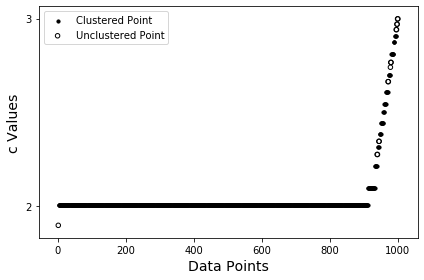

################################################################################################

################################################################################################

x1 vs x2

Time taken: 2.0125627517700195 seconds

Rule 1:-

Equation:   x1^(1.0) * x2^(-0.9990946934140543) = C

Total Significance:   99.0% (990 points out of 1000)

Cluster 1/14:-
C:   0.4009540958687291
Significance:   0.3% (3 points out of 1000)

Cluster 2/14:-
C:   0.40315311379609853
Significance:   0.3% (3 points out of 1000)

Cluster 3/14:-
C:   0.40865057993343923
Significance:   0.7% (7 points out of 1000)

Cluster 4/14:-
C:   0.41236502924507396
Significance:   0.3% (3 points out of 1000)

Cluster 5/14:-
C:   0.41902113941967084
Significance:   0.7% (7 points out of 1000)

Cluster 6/14:-
C:   0.42559493725765213
Significance:   0.6% (6 points out of 1000)

Cluster 7/14:-
C:   0.4349662053847282
Significance:   0.5% (5 points out of 1000)

Cluster 8/14:-
C:   0.44027882175414995
Sign

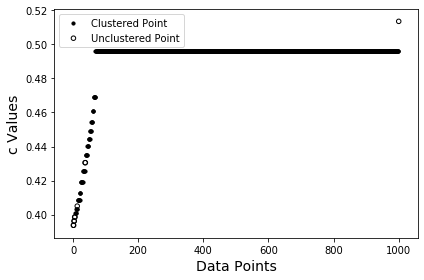

################################################################################################

################################################################################################

x1 vs V

Time taken: 2.815507411956787 seconds

Rule 1:-

Equation:   x1^(1.0) * V^(-0.9997588721972941) = C

Total Significance:   98.1% (981 points out of 1000)

Cluster 1/13:-
C:   0.07950202194850015
Significance:   0.4% (4 points out of 1000)

Cluster 2/13:-
C:   0.0803736913082457
Significance:   0.3% (3 points out of 1000)

Cluster 3/13:-
C:   0.08244870311804152
Significance:   0.5% (5 points out of 1000)

Cluster 4/13:-
C:   0.0855024546289438
Significance:   0.5% (5 points out of 1000)

Cluster 5/13:-
C:   0.08829092007474558
Significance:   0.6% (6 points out of 1000)

Cluster 6/13:-
C:   0.09149819323697136
Significance:   0.6% (6 points out of 1000)

Cluster 7/13:-
C:   0.09320092254244133
Significance:   0.3% (3 points out of 1000)

Cluster 8/13:-
C:   0.09460323687027826
Signifi

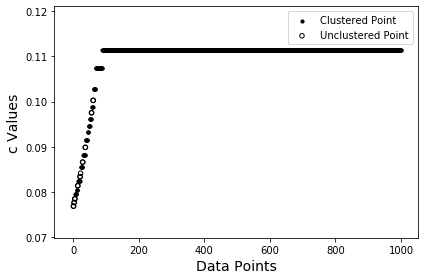

################################################################################################

################################################################################################

x1 vs S

Time taken: 2.7472007274627686 seconds

Rule 1:-

Equation:   x1^(1.0) * S^(0.9992846027792641) = C

Total Significance:   98.6% (986 points out of 1000)

Cluster 1/13:-
C:   33.845000429247484
Significance:   0.3% (3 points out of 1000)

Cluster 2/13:-
C:   34.095954260452
Significance:   0.4% (4 points out of 1000)

Cluster 3/13:-
C:   34.81394351875604
Significance:   0.8% (8 points out of 1000)

Cluster 4/13:-
C:   35.679302912303164
Significance:   0.7% (7 points out of 1000)

Cluster 5/13:-
C:   36.37691680848945
Significance:   0.6% (6 points out of 1000)

Cluster 6/13:-
C:   37.36573464941923
Significance:   0.5% (5 points out of 1000)

Cluster 7/13:-
C:   37.89674815497811
Significance:   0.4% (4 points out of 1000)

Cluster 8/13:-
C:   38.37764428757664
Significance:   0.4% 

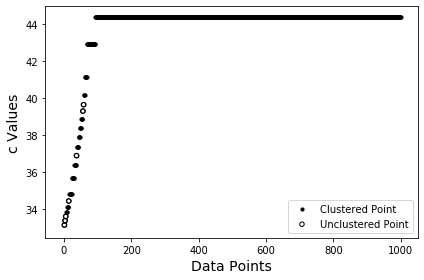

################################################################################################



In [70]:
SimultaneousDiscovery(dataset=data, plot_c_values=True).findRules().display()

# Beam Simultaneous Discovery

In [71]:
data2 = pd.read_csv("datasets/beam.csv")
data2 = data2[["b","t","l","h","C","D"]]
data2.head()

,b,t,l,h,C,D
0,0.237326,9.459139,2.644998,0.233506,1.957015,0.010929
1,5.000000,10.000000,0.307084,1.226737,34.926204,0.000439
2,0.235061,9.930760,2.469878,0.232046,1.996563,0.009536
3,0.236640,9.589799,2.572593,0.234508,1.965647,0.010519
4,0.234678,9.985173,2.410110,0.234617,1.996566,0.009396


130
138
141
144
169
303
302
417
435
444
454
488
163
0
149
152
176
184
188
192
197
200
656
################################################################################################

t

Time taken: 0.0076045989990234375 seconds

Rule 1:-

Equation:   t^(1) = C

Total Significance:   99.8% (998 points out of 1000)

Cluster 1/10:-
C:   9.46566247203525
Significance:   0.4% (4 points out of 1000)

Cluster 2/10:-
C:   9.52105307294297
Significance:   1.4% (14 points out of 1000)

Cluster 3/10:-
C:   9.643867211883405
Significance:   0.7% (7 points out of 1000)

Cluster 4/10:-
C:   9.687932747219088
Significance:   0.4% (4 points out of 1000)

Cluster 5/10:-
C:   9.710685900710823
Significance:   0.4% (4 points out of 1000)

Cluster 6/10:-
C:   9.74712609394056
Significance:   0.9% (9 points out of 1000)

Cluster 7/10:-
C:   9.792911312871814
Significance:   0.5% (5 points out of 1000)

Cluster 8/10:-
C:   9.862862617635306
Significance:   1.3% (13 points out of 1000)

Cluster 9/10:-
C

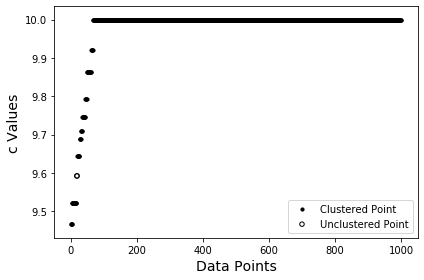

################################################################################################

################################################################################################

b vs l

Time taken: 2.3637475967407227 seconds

Rule 1:-

Equation:   b^(1.0) * l^(0.8013754097865646) = C

Total Significance:   100.0% (1000 points out of 1000)

Cluster 1/6:-
C:   0.4995287230382156
Significance:   56.5% (565 points out of 1000)

Cluster 2/6:-
C:   0.6679207605482839
Significance:   0.9% (9 points out of 1000)

Cluster 3/6:-
C:   0.6895319139171371
Significance:   1.2% (12 points out of 1000)

Cluster 4/6:-
C:   0.7800352745130437
Significance:   12.1% (121 points out of 1000)

Cluster 5/6:-
C:   0.9334103769676718
Significance:   7.8% (78 points out of 1000)

Cluster 6/6:-
C:   1.1988438136522492
Significance:   21.5% (215 points out of 1000)



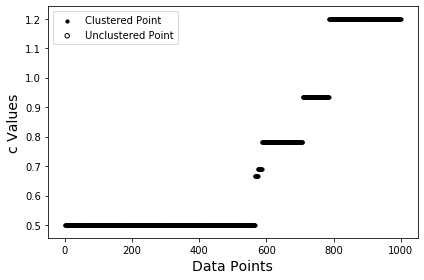

Rule 2:-

Equation:   b^(1.0) * l^(0.8635968232055001) = C

Total Significance:   100.0% (1000 points out of 1000)

Cluster 1/4:-
C:   0.5543576637905602
Significance:   75.1% (751 points out of 1000)

Cluster 2/4:-
C:   0.9263552312999148
Significance:   7.7% (77 points out of 1000)

Cluster 3/4:-
C:   1.0074617036434623
Significance:   4.5% (45 points out of 1000)

Cluster 4/4:-
C:   1.1848245546210738
Significance:   12.7% (127 points out of 1000)



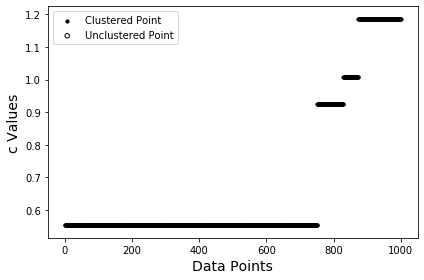

Rule 3:-

Equation:   b^(1.0) * l^(0.8955399771283441) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/2:-
C:   0.5151283105201276
Significance:   61.1% (611 points out of 1000)

Cluster 2/2:-
C:   0.9101662657611415
Significance:   38.8% (388 points out of 1000)



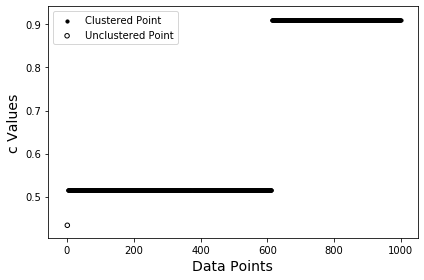

Rule 4:-

Equation:   b^(1.0) * l^(0.9175915218152585) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/4:-
C:   0.5125654709966976
Significance:   59.5% (595 points out of 1000)

Cluster 2/4:-
C:   0.6788892032058867
Significance:   9.0% (90 points out of 1000)

Cluster 3/4:-
C:   0.7872776115149464
Significance:   9.6% (96 points out of 1000)

Cluster 4/4:-
C:   1.0134557914892817
Significance:   21.8% (218 points out of 1000)



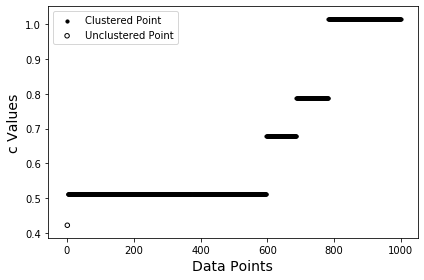

Rule 5:-

Equation:   b^(1.0) * l^(1.2006760245435835) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/3:-
C:   0.32994144581915846
Significance:   0.7% (7 points out of 1000)

Cluster 2/3:-
C:   0.35663882462983465
Significance:   1.0% (10 points out of 1000)

Cluster 3/3:-
C:   0.5583320586296042
Significance:   98.2% (982 points out of 1000)



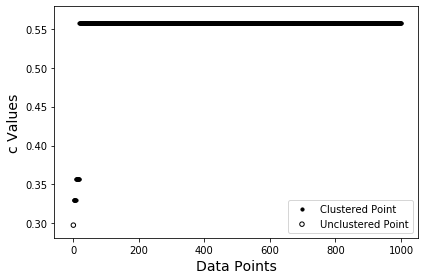

################################################################################################

################################################################################################

b vs h

Time taken: 2.376035213470459 seconds

Rule 1:-

Equation:   b^(1.0) * h^(-1.4844709879712812) = C

Total Significance:   99.8% (998 points out of 1000)

Cluster 1/5:-
C:   0.9845302755783155
Significance:   0.6% (6 points out of 1000)

Cluster 2/5:-
C:   1.0859647395089946
Significance:   1.0% (10 points out of 1000)

Cluster 3/5:-
C:   1.1474417274319888
Significance:   1.8% (18 points out of 1000)

Cluster 4/5:-
C:   1.68241022361731
Significance:   92.2% (922 points out of 1000)

Cluster 5/5:-
C:   2.4794100261382086
Significance:   4.2% (42 points out of 1000)



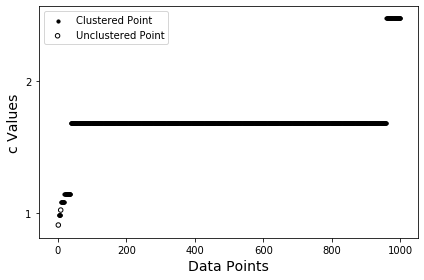

Rule 2:-

Equation:   b^(1.0) * h^(-1.2334965434243177) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/1:-
C:   1.5409187106883124
Significance:   99.9% (999 points out of 1000)



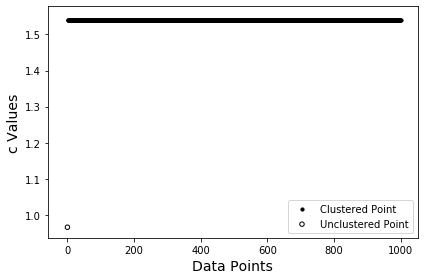

Rule 3:-

Equation:   b^(1.0) * h^(-1.1152123052712153) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/2:-
C:   1.2328908577195143
Significance:   68.8% (688 points out of 1000)

Cluster 2/2:-
C:   2.2050794534712352
Significance:   31.1% (311 points out of 1000)



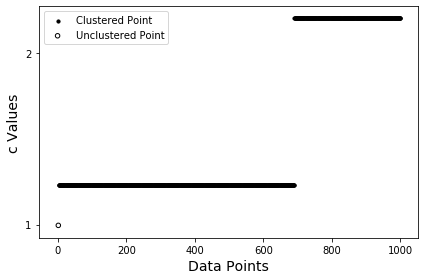

Rule 4:-

Equation:   b^(1.0) * h^(-1.0042812370900853) = C

Total Significance:   100.0% (1000 points out of 1000)

Cluster 1/10:-
C:   1.04299423031317
Significance:   51.2% (512 points out of 1000)

Cluster 2/10:-
C:   1.3177665751552265
Significance:   6.4% (64 points out of 1000)

Cluster 3/10:-
C:   1.4424154433537295
Significance:   0.5% (5 points out of 1000)

Cluster 4/10:-
C:   1.4550270371049634
Significance:   0.5% (5 points out of 1000)

Cluster 5/10:-
C:   1.4770673472841325
Significance:   0.5% (5 points out of 1000)

Cluster 6/10:-
C:   1.655833690925949
Significance:   12.6% (126 points out of 1000)

Cluster 7/10:-
C:   1.9855261136629265
Significance:   8.2% (82 points out of 1000)

Cluster 8/10:-
C:   2.318230589366928
Significance:   11.4% (114 points out of 1000)

Cluster 9/10:-
C:   2.718835470576522
Significance:   6.3% (63 points out of 1000)

Cluster 10/10:-
C:   3.0934557484713996
Significance:   2.4% (24 points out of 1000)



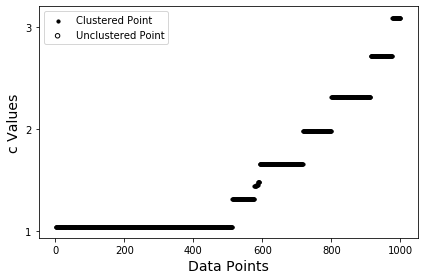

################################################################################################

################################################################################################

b vs D

Time taken: 3.8372435569763184 seconds

Rule 1:-

Equation:   b^(1.0) * D^(1.0000000000000002) = C

Total Significance:   99.8% (998 points out of 1000)

Cluster 1/10:-
C:   0.0021954302493632726
Significance:   93.3% (933 points out of 1000)

Cluster 2/10:-
C:   0.002248112159931543
Significance:   0.5% (5 points out of 1000)

Cluster 3/10:-
C:   0.0022783779812143206
Significance:   0.8% (8 points out of 1000)

Cluster 4/10:-
C:   0.0023036056303288857
Significance:   0.5% (5 points out of 1000)

Cluster 5/10:-
C:   0.0023374300859177175
Significance:   0.5% (5 points out of 1000)

Cluster 6/10:-
C:   0.0023705239143889047
Significance:   0.9% (9 points out of 1000)

Cluster 7/10:-
C:   0.002397310975509986
Significance:   0.4% (4 points out of 1000)

Cluster 8/10:-
C:   0.0024142417

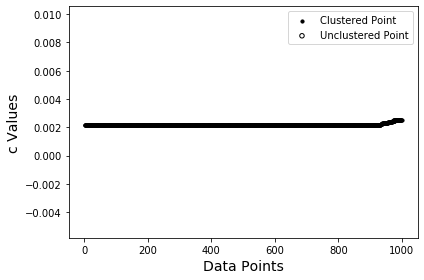

################################################################################################

################################################################################################

l vs C

Time taken: 2.8152267932891846 seconds

Rule 1:-

Equation:   l^(1.0) * C^(0.8747592349638617) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/4:-
C:   2.287660937157876
Significance:   0.7% (7 points out of 1000)

Cluster 2/4:-
C:   2.434402229200868
Significance:   1.0% (10 points out of 1000)

Cluster 3/4:-
C:   2.5355828698283
Significance:   1.8% (18 points out of 1000)

Cluster 4/4:-
C:   3.6154482715193996
Significance:   96.4% (964 points out of 1000)



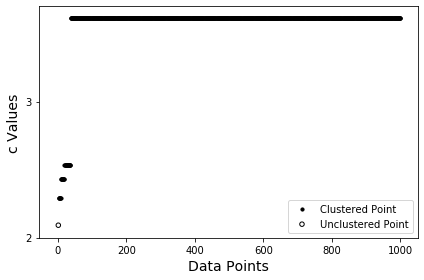

Rule 2:-

Equation:   l^(1.0) * C^(0.8887137575246674) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/2:-
C:   2.5338678369183425
Significance:   3.5% (35 points out of 1000)

Cluster 2/2:-
C:   3.717867078369676
Significance:   96.4% (964 points out of 1000)



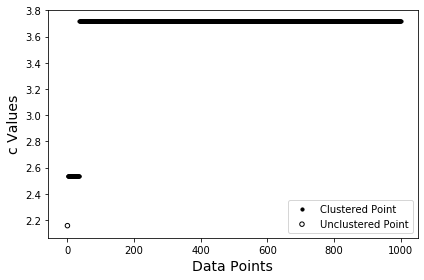

Rule 3:-

Equation:   l^(1.0) * C^(1.1190928770627486) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/2:-
C:   4.882795812982782
Significance:   68.5% (685 points out of 1000)

Cluster 2/2:-
C:   8.582032554870363
Significance:   31.4% (314 points out of 1000)



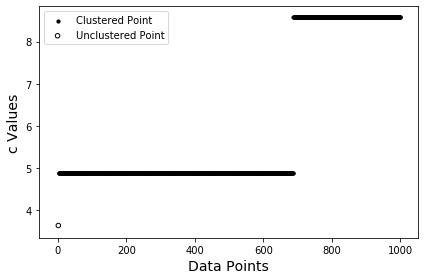

Rule 4:-

Equation:   l^(1.0) * C^(1.2109888276111695) = C

Total Significance:   100.0% (1000 points out of 1000)

Cluster 1/5:-
C:   5.316641676784492
Significance:   58.8% (588 points out of 1000)

Cluster 2/5:-
C:   7.056233884655021
Significance:   1.8% (18 points out of 1000)

Cluster 3/5:-
C:   7.827745836597874
Significance:   9.0% (90 points out of 1000)

Cluster 4/5:-
C:   9.071976293482084
Significance:   5.5% (55 points out of 1000)

Cluster 5/5:-
C:   12.217387058534278
Significance:   24.9% (249 points out of 1000)



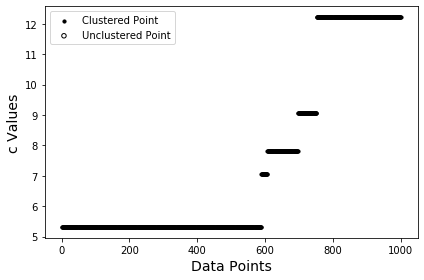

Rule 5:-

Equation:   l^(1.0) * C^(1.269649781766313) = C

Total Significance:   100.0% (1000 points out of 1000)

Cluster 1/5:-
C:   5.673377710447121
Significance:   56.6% (566 points out of 1000)

Cluster 2/5:-
C:   7.471835984226145
Significance:   0.5% (5 points out of 1000)

Cluster 3/5:-
C:   8.28102488905861
Significance:   6.6% (66 points out of 1000)

Cluster 4/5:-
C:   11.43528351872889
Significance:   24.0% (240 points out of 1000)

Cluster 5/5:-
C:   16.994602179129373
Significance:   12.3% (123 points out of 1000)



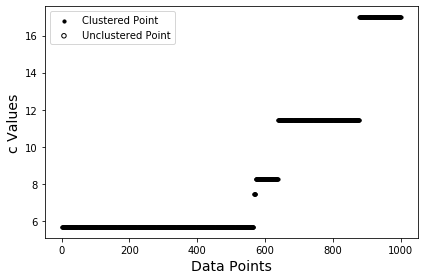

Rule 6:-

Equation:   l^(1.0) * C^(1.304627786838453) = C

Total Significance:   99.9% (999 points out of 1000)

Cluster 1/6:-
C:   5.88063636963793
Significance:   55.0% (550 points out of 1000)

Cluster 2/6:-
C:   7.92852594533058
Significance:   2.3% (23 points out of 1000)

Cluster 3/6:-
C:   9.431420880788886
Significance:   9.9% (99 points out of 1000)

Cluster 4/6:-
C:   10.624675938372885
Significance:   1.7% (17 points out of 1000)

Cluster 5/6:-
C:   11.170151441557657
Significance:   1.7% (17 points out of 1000)

Cluster 6/6:-
C:   15.76946763969238
Significance:   29.3% (293 points out of 1000)



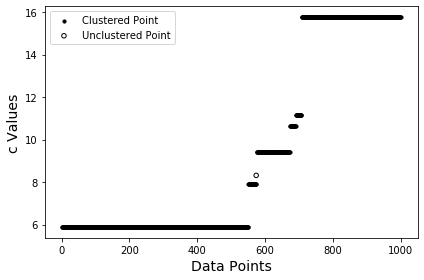

Rule 7:-

Equation:   l^(1.0) * C^(1.3912696431833915) = C

Total Significance:   99.2% (992 points out of 1000)

Cluster 1/14:-
C:   6.352003487826942
Significance:   49.3% (493 points out of 1000)

Cluster 2/14:-
C:   8.039660496795197
Significance:   3.2% (32 points out of 1000)

Cluster 3/14:-
C:   8.563933189210415
Significance:   0.3% (3 points out of 1000)

Cluster 4/14:-
C:   8.877148917315143
Significance:   2.0% (20 points out of 1000)

Cluster 5/14:-
C:   9.359319341251581
Significance:   0.5% (5 points out of 1000)

Cluster 6/14:-
C:   9.552892727264714
Significance:   0.8% (8 points out of 1000)

Cluster 7/14:-
C:   9.992036579562145
Significance:   0.5% (5 points out of 1000)

Cluster 8/14:-
C:   10.597356368078428
Significance:   3.0% (30 points out of 1000)

Cluster 9/14:-
C:   11.359673674842409
Significance:   1.6% (16 points out of 1000)

Cluster 10/14:-
C:   12.612740734909595
Significance:   7.4% (74 points out of 1000)

Cluster 11/14:-
C:   13.849098997088815
Sign

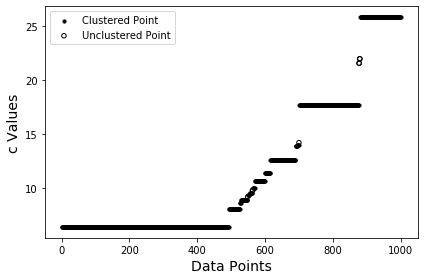

Rule 8:-

Equation:   l^(1.0) * C^(1.438362894138642) = C

Total Significance:   98.9% (989 points out of 1000)

Cluster 1/19:-
C:   6.528751606008741
Significance:   42.0% (420 points out of 1000)

Cluster 2/19:-
C:   7.3460856688631955
Significance:   2.1% (21 points out of 1000)

Cluster 3/19:-
C:   7.937474154236816
Significance:   5.3% (53 points out of 1000)

Cluster 4/19:-
C:   8.845612901961479
Significance:   3.1% (31 points out of 1000)

Cluster 5/19:-
C:   9.743001388492791
Significance:   1.7% (17 points out of 1000)

Cluster 6/19:-
C:   10.057868773407884
Significance:   0.3% (3 points out of 1000)

Cluster 7/19:-
C:   10.342003738784083
Significance:   0.8% (8 points out of 1000)

Cluster 8/19:-
C:   10.627728344817301
Significance:   0.4% (4 points out of 1000)

Cluster 9/19:-
C:   11.433880473982686
Significance:   1.1% (11 points out of 1000)

Cluster 10/19:-
C:   11.89521233078995
Significance:   1.5% (15 points out of 1000)

Cluster 11/19:-
C:   12.272254157379285
Si

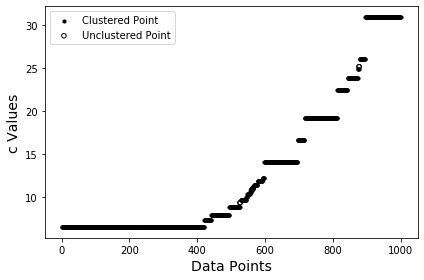

Rule 9:-

Equation:   l^(1.0) * C^(-6.123233995736766e-17) = C

Total Significance:   98.6% (986 points out of 1000)

Cluster 1/35:-
C:   0.2149553224724949
Significance:   25.3% (253 points out of 1000)

Cluster 2/35:-
C:   0.24603025541400841
Significance:   0.4% (4 points out of 1000)

Cluster 3/35:-
C:   0.2600931023249981
Significance:   1.0% (10 points out of 1000)

Cluster 4/35:-
C:   0.29200066042587314
Significance:   5.0% (50 points out of 1000)

Cluster 5/35:-
C:   0.30719374251448633
Significance:   2.6% (26 points out of 1000)

Cluster 6/35:-
C:   0.3484201478996518
Significance:   0.9% (9 points out of 1000)

Cluster 7/35:-
C:   0.4198768181350944
Significance:   11.0% (110 points out of 1000)

Cluster 8/35:-
C:   0.4608477876748081
Significance:   1.1% (11 points out of 1000)

Cluster 9/35:-
C:   0.550728817940307
Significance:   6.4% (64 points out of 1000)

Cluster 10/35:-
C:   0.6578434421862788
Significance:   3.7% (37 points out of 1000)

Cluster 11/35:-
C:   0.7756

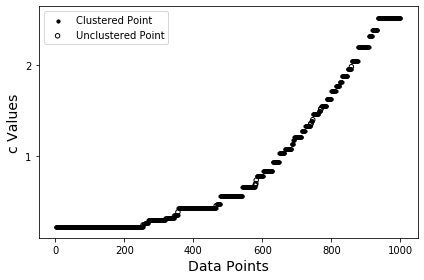

################################################################################################



In [87]:
SimultaneousDiscovery(dataset=data2, plot_c_values=True).findRules().display()